# Makemore pt 2
Build a character-level language model that has greater than one character of context using feature vectors.
It follows [Bengio et al 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random

In [31]:
# Mac OS GPU acceleration or CPU
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")
print(device)

cpu


In [32]:
# Load names from file
words = open('names.txt', 'r').read().splitlines()
print(words[:5])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [33]:
# Create vocab of characters to integers
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print('stoi', stoi)
print('itos', itos)

stoi {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [44]:
# Create dataset
block_size = 4 # char context length

def build_dataset(words):
    X, Y = [], [] # X = Data, Y = Target
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch] # next char to be predicted and added to context
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

train_n = int(len(words) * 0.8)
dev_n = int(len(words) * 0.1)
test_n = len(words) - train_n - dev_n
train_words = words[:train_n]
dev_words = words[train_n:train_n+dev_n]
test_words = words[train_n+dev_n:]

train_X, train_Y = build_dataset(train_words)
dev_X, dev_Y = build_dataset(dev_words)
test_X, test_Y = build_dataset(test_words)

19362


  0%|          | 151/300000 [00:00<03:19, 1505.84it/s]

train loss step 0: 34.145320892333984
dev loss step 0: 32.56587600708008


  3%|▎         | 10393/300000 [00:03<01:40, 2895.60it/s]

train loss step 10000: 2.958763360977173
dev loss step 10000: 3.436159372329712


  7%|▋         | 20309/300000 [00:06<01:41, 2752.01it/s]

train loss step 20000: 2.4016122817993164
dev loss step 20000: 2.7614588737487793


 10%|█         | 30322/300000 [00:10<01:34, 2845.64it/s]

train loss step 30000: 3.0910849571228027
dev loss step 30000: 3.0149550437927246


 13%|█▎        | 40292/300000 [00:13<01:34, 2755.91it/s]

train loss step 40000: 2.7292912006378174
dev loss step 40000: 2.6587860584259033


 17%|█▋        | 50283/300000 [00:17<01:31, 2744.11it/s]

train loss step 50000: 2.376866340637207
dev loss step 50000: 3.129843235015869


 20%|██        | 60409/300000 [00:20<01:25, 2817.60it/s]

train loss step 60000: 2.181061029434204
dev loss step 60000: 2.7922277450561523


 23%|██▎       | 70484/300000 [00:24<01:20, 2867.81it/s]

train loss step 70000: 2.2221014499664307
dev loss step 70000: 2.494886875152588


 27%|██▋       | 80513/300000 [00:27<01:17, 2843.76it/s]

train loss step 80000: 2.292564868927002
dev loss step 80000: 2.574760913848877


 30%|███       | 90495/300000 [00:31<01:14, 2805.23it/s]

train loss step 90000: 2.0940659046173096
dev loss step 90000: 2.5753650665283203


 34%|███▎      | 100535/300000 [00:34<01:10, 2839.05it/s]

train loss step 100000: 2.452760696411133
dev loss step 100000: 2.509636163711548


 37%|███▋      | 110264/300000 [00:38<01:08, 2787.79it/s]

train loss step 110000: 2.277578353881836
dev loss step 110000: 2.483738899230957


 40%|████      | 120280/300000 [00:41<01:04, 2790.06it/s]

train loss step 120000: 2.416219472885132
dev loss step 120000: 2.463045597076416


 43%|████▎     | 130262/300000 [00:44<01:00, 2784.12it/s]

train loss step 130000: 2.5869953632354736
dev loss step 130000: 2.540440320968628


 47%|████▋     | 140296/300000 [00:48<00:56, 2802.53it/s]

train loss step 140000: 2.307955503463745
dev loss step 140000: 2.4781429767608643


 50%|█████     | 150321/300000 [00:51<00:52, 2831.07it/s]

train loss step 150000: 2.4325172901153564
dev loss step 150000: 2.515577793121338


 53%|█████▎    | 160376/300000 [00:55<00:49, 2835.92it/s]

train loss step 160000: 1.9120358228683472
dev loss step 160000: 2.439711570739746


 57%|█████▋    | 170402/300000 [00:58<00:45, 2831.30it/s]

train loss step 170000: 1.9031037092208862
dev loss step 170000: 2.4388012886047363


 60%|██████    | 180406/300000 [01:02<00:42, 2810.98it/s]

train loss step 180000: 2.0294623374938965
dev loss step 180000: 2.5061299800872803


 63%|██████▎   | 190435/300000 [01:05<00:39, 2779.73it/s]

train loss step 190000: 2.4616165161132812
dev loss step 190000: 2.502969980239868


 67%|██████▋   | 200485/300000 [01:09<00:35, 2829.40it/s]

train loss step 200000: 1.9972374439239502
dev loss step 200000: 2.506375789642334


 70%|███████   | 210500/300000 [01:12<00:31, 2805.05it/s]

train loss step 210000: 2.004676103591919
dev loss step 210000: 2.426375389099121


 73%|███████▎  | 220474/300000 [01:15<00:28, 2821.80it/s]

train loss step 220000: 2.333854913711548
dev loss step 220000: 2.4893949031829834


 77%|███████▋  | 230533/300000 [01:19<00:24, 2836.33it/s]

train loss step 230000: 2.181436777114868
dev loss step 230000: 2.423083782196045


 80%|████████  | 240272/300000 [01:22<00:21, 2780.69it/s]

train loss step 240000: 2.154151678085327
dev loss step 240000: 2.445754051208496


 83%|████████▎ | 250353/300000 [01:26<00:17, 2828.97it/s]

train loss step 250000: 2.0399959087371826
dev loss step 250000: 2.376593828201294


 87%|████████▋ | 260410/300000 [01:29<00:14, 2781.77it/s]

train loss step 260000: 1.9501099586486816
dev loss step 260000: 2.364531993865967


 90%|█████████ | 270471/300000 [01:33<00:10, 2841.12it/s]

train loss step 270000: 2.1128108501434326
dev loss step 270000: 2.4174389839172363


 93%|█████████▎| 280241/300000 [01:36<00:07, 2777.64it/s]

train loss step 280000: 1.9285035133361816
dev loss step 280000: 2.378237247467041


 97%|█████████▋| 290313/300000 [01:39<00:03, 2822.16it/s]

train loss step 290000: 1.7809323072433472
dev loss step 290000: 2.3534300327301025


100%|██████████| 300000/300000 [01:43<00:00, 2909.55it/s]


train loss final: 2.1975927352905273
dev loss final: 2.3683066368103027
test loss final: 2.4074528217315674


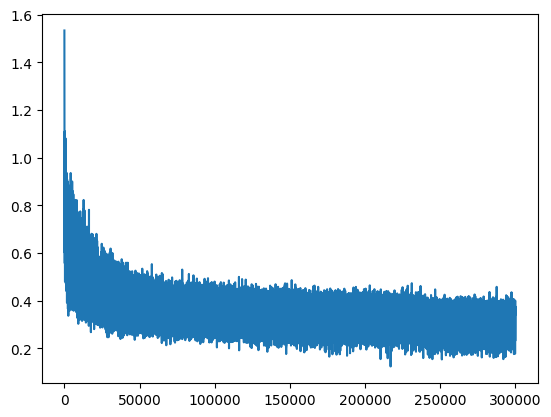

In [41]:
# Build C matrix = character-level embeddings to be used as inputs vectors
g = torch.Generator().manual_seed(2147483647)

C_dim = 5
C = torch.randn((27, C_dim), generator=g, device=device)
fc_layer_size = 400

# Indexing into C is the same as one hot encoded vector @ C
# emb = C[X]

# Define the weight matrix
W1 = torch.randn((block_size * C_dim,fc_layer_size), generator=g, device=device)
b1 = torch.randn(fc_layer_size, generator=g, device=device)

# Output layer
W2 = torch.randn((fc_layer_size,27), generator=g, device=device)
b2 = torch.randn(27, generator=g, device=device)

# Sum number of parameters
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

print(sum(p.numel() for p in parameters))

# Hyperparameter search through possibl elearning rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# print(lrs)

lri, lossi, stepi = [], [], []

# Hyperparameters
num_steps = 300000
batch_size = 64

# Full training loop
for i in tqdm(range(num_steps)):

    # Minibatch construction
    ix = torch.randint(0, train_X.shape[0], (batch_size,), device=device)

    emb = C[train_X[ix]]

    h = torch.tanh(emb.view(-1,block_size * C_dim) @ W1 + b1)
    logits = h @ W2 + b2

    # Softmax
    loss = F.cross_entropy(logits, train_Y[ix])

    # prob = F.softmax(logits, dim=1)
    # print(prob[0,:].sum())

    # # Compute loss
    # loss = - prob[torch.arange(32), Y].log().mean()

    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    # Update parameters
    # lr = lrs[i] # used for testing
    if i < num_steps / 5 * 4:
        lr = 0.1 
    else:
        lr = 0.05
    # else:
    #     lr = 0.001

    for p in parameters:
        p.data -= lr * p.grad
    
    # Track stats    
    # lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)

    if i % 10000 == 0:
        # Eval (trying to beat loss = 2.17)
        print(f'train loss step {i}: {loss.item()}')

        emb = C[dev_X]
        h = torch.tanh(emb.view(-1,block_size * C_dim) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, dev_Y)
        print(f'dev loss step {i}: {loss.item()}')

print(f'train loss final: {loss.item()}')

# Dev loss
emb = C[dev_X]
h = torch.tanh(emb.view(-1,block_size * C_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, dev_Y)
print(f'dev loss final: {loss.item()}')

# Test (trying to beat loss = 2.17)
emb = C[test_X]
h = torch.tanh(emb.view(-1, block_size * C_dim) @ W1 + b1)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, test_Y)

print(f'test loss final: {loss.item()}')

# Plot loss
plt.plot(stepi, lossi)


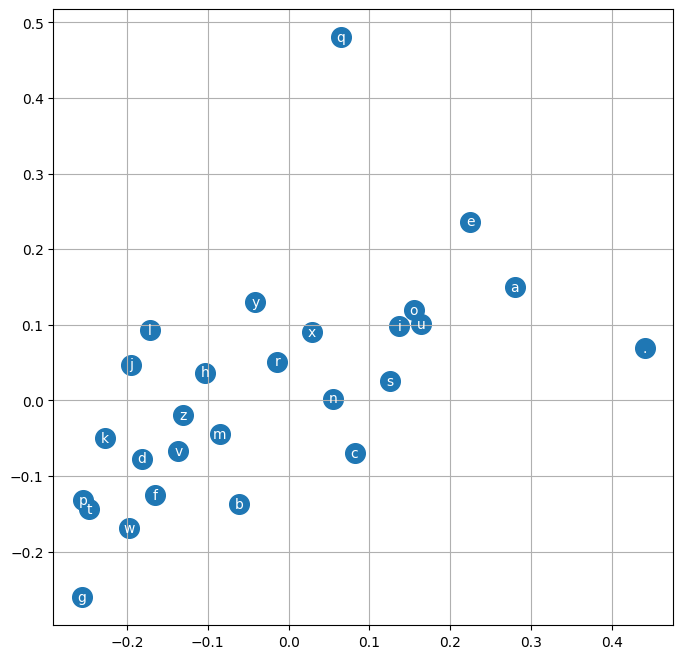

In [36]:
# Embedding locations
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], color='white', ha='center', va='center')
plt.grid('minor')

In [43]:
# Seeing results
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1,block_size * C_dim) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[ix] for ix in out))

stiandra.
layne.
rolynn.
kylani.
tharoia.
zana.
tene.
ilea.
cynleigha.
shai.
braysor.
lyfa.
tynzley.
komoseas.
dauly.
pertos.
zanvi.
joste.
averya.
teaco.
